In [2]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [6]:
rootdir = "/home/akshay/research/burrito"
outdirs = [ "tput-d88f7ab"]
datapaths = ['kernel', 'dpdkinline', 'dpdkthread']
num_clients = [1,2,4,8,16,32,64]
file_sizes = [50000000]

In [7]:
# note: this aggregates requestclients together

'''
def read_kv_csv(fn):
    with open(fn, 'r') as f:
        records = []
        for line in f:
            rec = {}
            for fld in line.split(','):
                col, val = fld.split('=')
                if '.' not in val:
                    rec[col] = int(val)
                else:
                    rec[col] = float(val)
            records.append(rec)
        return records
'''

def read_exp(outdir, dp, nc, fs):
    df = pd.DataFrame()
    for i in range(10):
        fn = f"{rootdir}/{outdir}/{dp}-num_clients={nc}-file_size={fs}-{i}-tbench_client-10.10.1.1.data"
        try:
            df_iter = pd.read_csv(fn)
            #df_iter["iter"] = i
            df_iter["Commit"] = outdir
            df_iter["Datapath"] = dp
            del df_iter["download_size"]
            del df_iter["elapsed_us"]
            del df_iter['tot_bytes']
            df = df.append(df_iter)
        except Exception as e:
            print(e)
            pass
    return df

exps = None
for outdir in outdirs:
    for dp in datapaths:
        for nc in num_clients:
            for fs in file_sizes:
                df = read_exp(outdir, dp, nc, fs)
                if exps is None:
                    exps = df
                else:
                    exps = exps.append(df)

exps = exps.groupby(["Commit", "Datapath", "num_clients"]).quantile([0.25, 0.5, 0.75])
exps = exps.unstack()
exps.columns = [f"{s}_{t}" for s,t in exps.columns.values]
exps.columns = exps.columns.to_flat_index()
exps = exps.reset_index()
exps

,Commit,Datapath,num_clients,rate_bps_0.25,rate_bps_0.5,rate_bps_0.75
0,tput-d88f7ab,dpdkinline,1,7.388758e+09,7.397222e+09,7.401277e+09
1,tput-d88f7ab,dpdkinline,2,8.357990e+09,8.358929e+09,8.360915e+09
2,tput-d88f7ab,dpdkinline,4,8.939914e+09,8.940996e+09,8.941615e+09
3,tput-d88f7ab,dpdkinline,8,9.255422e+09,9.257763e+09,9.260581e+09
4,tput-d88f7ab,dpdkinline,16,8.413766e+09,8.417201e+09,8.420464e+09
5,tput-d88f7ab,dpdkinline,32,8.064014e+09,8.293953e+09,8.483804e+09
6,tput-d88f7ab,dpdkinline,64,7.954386e+09,8.536346e+09,8.782681e+09
7,tput-d88f7ab,dpdkthread,1,5.182676e+09,5.294404e+09,5.358842e+09
8,tput-d88f7ab,dpdkthread,2,4.037327e+09,4.077337e+09,4.145252e+09
9,tput-d88f7ab,dpdkthread,4,3.037173e+09,3.075330e+09,3.197522e+09


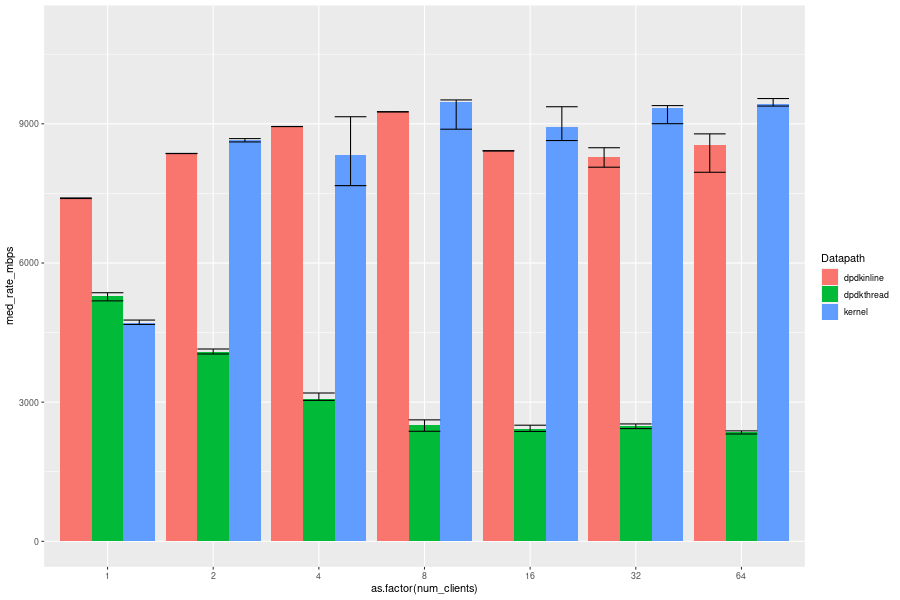

In [8]:
%%R -i exps -w 900 -h 600

library(ggplot2)

exps$med_rate_mbps <- exps$rate_bps_0.5 / 1e6
exps$low_rate_mbps <- exps$rate_bps_0.25 / 1e6
exps$hih_rate_mbps <- exps$rate_bps_0.75 / 1e6
ggplot(exps, aes(x=as.factor(num_clients), y=med_rate_mbps, fill=Datapath)) +
  geom_col(position="dodge") +
  geom_errorbar(aes(ymin=low_rate_mbps, ymax=hih_rate_mbps), position="dodge") +
  coord_cartesian(ylim=c(0,11e3))

In [7]:
exps.to_csv("./throughput-bench.csv")